In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data Inspection & Preprocessing

In [18]:
# Load the dataset
file_path = '/content/drive/MyDrive/events.csv'
df = pd.read_csv(file_path)

# Display initial information about the dataset
print("Initial dataset overview:")
print(df.info())
print("\nFirst few rows of the dataset:")
print(df.head())

# Handle missing values
print("\nHandling missing values...")
missing_summary = df.isnull().sum()
print("Missing values before handling:\n", missing_summary)

# Drop rows with critical missing values (if event_time, product_id, or user_id is missing)
df.dropna(subset=['event_time', 'product_id', 'user_id'], inplace=True)

# For other columns, fill missing values with placeholders or defaults
df['category_code'].fillna('unknown', inplace=True)
df['brand'].fillna('unknown', inplace=True)

# Check for duplicates
print("\nChecking for duplicates...")
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
df.drop_duplicates(inplace=True)

# Parse event_time and ensure correct data types
print("\nParsing event_time and converting data types...")
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')

# Ensure all other columns have correct data types
df['event_type'] = df['event_type'].astype('category')
df['product_id'] = df['product_id'].astype(str)
df['category_id'] = df['category_id'].astype(str)
df['brand'] = df['brand'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['user_session'] = df['user_session'].astype(str)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Handle any rows with invalid event_time or price
df.dropna(subset=['event_time', 'price'], inplace=True)

# Final dataset overview
print("\nFinal dataset overview:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

# Save the cleaned dataset for further use
cleaned_file_path = '/content/drive/MyDrive/cleaned_events.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaned dataset saved to {cleaned_file_path}")


Initial dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB
None

First few rows of the dataset:
                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      2154

<ipython-input-18-f05b3b118bf9>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna('unknown', inplace=True)
<ipython-input-18-f05b3b118bf9>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Number of duplicate rows: 655

Parsing event_time and converting data types...

Final dataset overview:
<class 'pandas.core.frame.DataFrame'>
Index: 884474 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     884474 non-null  datetime64[ns, UTC]
 1   event_type     884474 non-null  category           
 2   product_id     884474 non-null  object             
 3   category_id    884474 non-null  object             
 4   category_code  884474 non-null  object             
 5   brand          884474 non-null  object             
 6   price          884474 non-null  float64            
 7   user_id        884474 non-null  object             
 8   user_session   884474 non-null  object             
dtypes: category(1), datetime64[ns, UTC](1), float64(1), object(6)
memory usage: 61.6+ MB
None

Summary statistics:
                                 event_time even

**Checking the cleaned data quality**

In [19]:

def check_data_cleanliness(file_path):
    """
    Checks the cleanliness of a dataset.

    Parameters:
        file_path (str): Path to the cleaned dataset file.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    print("Checking dataset cleanliness...\n")

    # Check for missing values
    missing_summary = df.isnull().sum()
    total_missing = missing_summary.sum()
    print("Missing Values Summary:")
    print(missing_summary)
    if total_missing == 0:
        print("\nNo missing values found.")
    else:
        print(f"\nTotal missing values: {total_missing}")

    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    print("\nDuplicate Rows Check:")
    if duplicate_count == 0:
        print("No duplicate rows found.")
    else:
        print(f"Number of duplicate rows: {duplicate_count}")

    # Validate data types
    print("\nData Types Check:")
    expected_types = {
        'event_time': 'datetime64[ns]',
        'event_type': 'category',
        'product_id': 'object',
        'category_id': 'object',
        'category_code': 'object',
        'brand': 'object',
        'price': 'float64',
        'user_id': 'object',
        'user_session': 'object'
    }
    type_issues = []
    for col, expected_type in expected_types.items():
        if col in df.columns:
            actual_type = str(df[col].dtype)
            if actual_type != expected_type:
                type_issues.append((col, expected_type, actual_type))
    if not type_issues:
        print("All columns have expected data types.")
    else:
        print("Columns with incorrect data types:")
        for col, expected, actual in type_issues:
            print(f"- {col}: expected {expected}, but got {actual}")

    # Check for outliers in numerical data
    print("\nNumerical Outliers Check:")
    if 'price' in df.columns:
        price_stats = df['price'].describe()
        print(price_stats)
        if price_stats['min'] < 0:
            print("Warning: Negative prices found.")
        else:
            print("No negative prices found.")

    print("\nData cleanliness check completed.")

# Example usage
cleaned_file_path = '/content/drive/MyDrive/cleaned_events.csv'
check_data_cleanliness(cleaned_file_path)


Checking dataset cleanliness...

Missing Values Summary:
event_time         0
event_type         0
product_id         0
category_id        0
category_code      0
brand              0
price              0
user_id            0
user_session     162
dtype: int64

Total missing values: 162

Duplicate Rows Check:
No duplicate rows found.

Data Types Check:
Columns with incorrect data types:
- event_time: expected datetime64[ns], but got object
- event_type: expected category, but got object
- product_id: expected object, but got int64
- category_id: expected object, but got int64
- user_id: expected object, but got int64

Numerical Outliers Check:
count    884474.000000
mean        146.331556
std         296.864505
min           0.220000
25%          26.460000
50%          65.710000
75%         190.540000
max       64771.060000
Name: price, dtype: float64
No negative prices found.

Data cleanliness check completed.


**Final Cleaning of Dataset**

In [20]:

# Load the dataset
file_path = '/content/drive/MyDrive/events.csv'
df = pd.read_csv(file_path)

# Initial dataset overview
print("Initial dataset overview:")
print(df.info())
print("\nFirst few rows of the dataset:")
print(df.head())

# Handle missing values
print("\nHandling missing values...")
df.dropna(subset=['event_time', 'product_id', 'user_id'], inplace=True)  # Drop rows with critical missing values
df['category_code'].fillna('unknown', inplace=True)  # Fill missing 'category_code' with 'unknown'
df['brand'].fillna('unknown', inplace=True)         # Fill missing 'brand' with 'unknown'
df['user_session'].fillna('unknown', inplace=True)  # Fill missing 'user_session' with 'unknown'

# Check and remove duplicates
print("\nChecking for duplicates...")
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
df.drop_duplicates(inplace=True)

# Parse 'event_time' and correct data types
print("\nParsing event_time and converting data types...")
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')  # Convert to datetime
df['event_type'] = df['event_type'].astype('category')  # Convert to category
df['product_id'] = df['product_id'].astype(str)         # Convert to string
df['category_id'] = df['category_id'].astype(str)       # Convert to string
df['brand'] = df['brand'].astype(str)                  # Convert to string
df['user_id'] = df['user_id'].astype(str)              # Convert to string
df['user_session'] = df['user_session'].astype(str)    # Convert to string
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # Ensure price is numeric
df.dropna(subset=['event_time', 'price'], inplace=True)  # Drop rows with invalid event_time or price

# Investigate and handle outliers in 'price'
price_threshold = df['price'].quantile(0.99)  # Set threshold at the 99th percentile
df['price'] = df['price'].clip(upper=price_threshold)  # Cap prices at the threshold

# Save the intermediate cleaned dataset
intermediate_cleaned_file = '/content/drive/MyDrive/cleaned_events.csv'
df.to_csv(intermediate_cleaned_file, index=False)
print(f"\nIntermediate cleaned dataset saved to {intermediate_cleaned_file}")

# Final cleanliness and quality check function
def check_cleanliness(df):
    print("\nFinal Cleanliness and Quality Report:")

    # Check for missing values
    missing_summary = df.isnull().sum()
    total_missing = missing_summary.sum()
    print("\nMissing Values Summary:")
    print(missing_summary)
    print(f"Total missing values: {total_missing}")

    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    print("\nDuplicate Rows Check:")
    print(f"Number of duplicate rows: {duplicate_count}")

    # Validate data types
    print("\nData Types Check:")
    expected_types = {
        'event_time': 'datetime64[ns]',
        'event_type': 'category',
        'product_id': 'object',
        'category_id': 'object',
        'category_code': 'object',
        'brand': 'object',
        'price': 'float64',
        'user_id': 'object',
        'user_session': 'object'
    }
    for col, expected in expected_types.items():
        if col in df.columns and str(df[col].dtype) != expected:
            print(f"- {col}: expected {expected}, but got {df[col].dtype}")
        else:
            print(f"- {col}: OK")

    # Check for numerical outliers in 'price'
    print("\nNumerical Outliers Check:")
    if 'price' in df.columns:
        price_stats = df['price'].describe()
        print(price_stats)

# Save the finalized cleaned dataset
final_cleaned_file_path = '/content/drive/MyDrive/cleaned_events.csv'
df.to_csv(final_cleaned_file_path, index=False)
print(f"\nFinal cleaned dataset saved to {final_cleaned_file_path}")

# Re-check cleanliness
check_cleanliness(df)


Initial dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB
None

First few rows of the dataset:
                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      2154

<ipython-input-20-9de95b999e3d>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna('unknown', inplace=True)  # Fill missing 'category_code' with 'unknown'
<ipython-input-20-9de95b999e3d>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d


Checking for duplicates...
Number of duplicate rows: 655

Parsing event_time and converting data types...

Intermediate cleaned dataset saved to /content/drive/MyDrive/cleaned_events.csv

Final cleaned dataset saved to /content/drive/MyDrive/cleaned_events.csv

Final Cleanliness and Quality Report:

Missing Values Summary:
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64
Total missing values: 0

Duplicate Rows Check:
Number of duplicate rows: 0

Data Types Check:
- event_time: expected datetime64[ns], but got datetime64[ns, UTC]
- event_type: OK
- product_id: OK
- category_id: OK
- category_code: OK
- brand: OK
- price: OK
- user_id: OK
- user_session: OK

Numerical Outliers Check:
count    884474.000000
mean        139.429709
std         171.792184
min           0.220000
25%          26.460000
50%          65.710000
75%         190.540000
max         

# Exploratory Data Analysis (EDA)

**1. Loading and overviewing of Dataset**

In [21]:

# Load the cleaned dataset
file_path = '/content/drive/MyDrive/cleaned_events.csv'
df = pd.read_csv(file_path, parse_dates=['event_time'])

# Set the style for visualizations
sns.set_theme(style="whitegrid")

# Overview of the dataset
print("Dataset Overview:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884474 entries, 0 to 884473
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     884474 non-null  datetime64[ns, UTC]
 1   event_type     884474 non-null  object             
 2   product_id     884474 non-null  int64              
 3   category_id    884474 non-null  int64              
 4   category_code  884474 non-null  object             
 5   brand          884474 non-null  object             
 6   price          884474 non-null  float64            
 7   user_id        884474 non-null  int64              
 8   user_session   884474 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 60.7+ MB
None

First few rows:
                 event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06+00:00       view     1996170  214441592

**2. Event distributions over time**


Event Distribution Analysis:

Event type distribution:
 event_type
view        793099
cart         54032
purchase     37343
Name: count, dtype: int64


<ipython-input-22-726a6d7f58b1>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='event_type', order=event_distribution.index, palette="viridis")


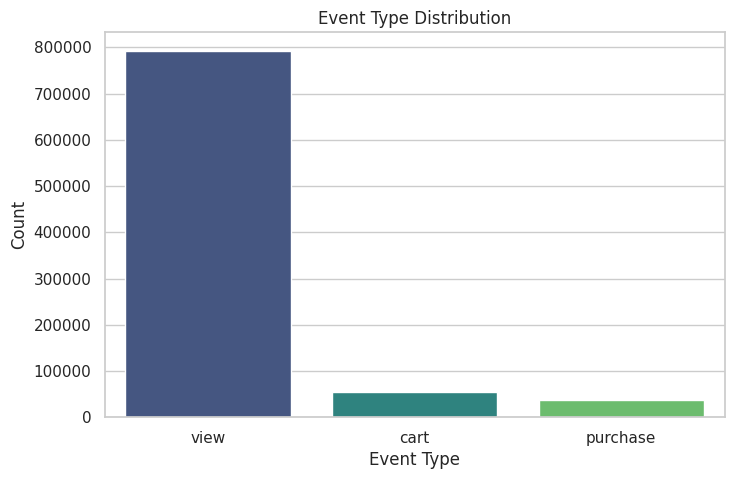

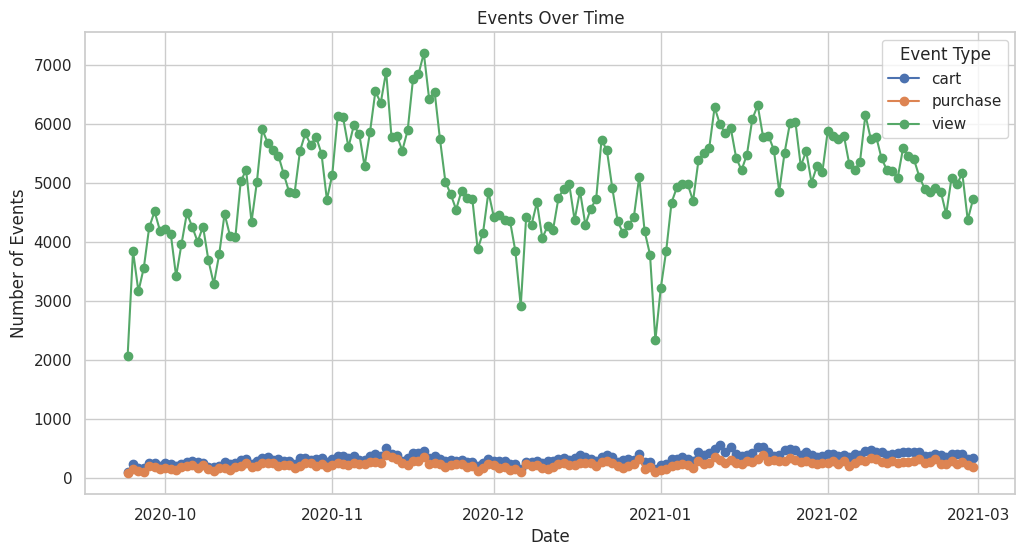

In [22]:
# ------------------------------
# Event distributions over time
# ------------------------------
print("\nEvent Distribution Analysis:")

# Convert event_time to date for daily aggregation
df['event_date'] = df['event_time'].dt.date

# Event count by type
event_distribution = df['event_type'].value_counts()
print("\nEvent type distribution:\n", event_distribution)

# Plot event distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='event_type', order=event_distribution.index, palette="viridis")
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

# Events over time
event_time_dist = df.groupby(['event_date', 'event_type']).size().unstack()
event_time_dist.plot(figsize=(12, 6), marker='o')
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend(title="Event Type")
plt.grid(True)
plt.show()

**3. Brand and category popularity**


Brand and Category Popularity:

Top 10 Categories:
 category_code
unknown                             236047
computers.components.videocards     116611
electronics.telephone                84308
computers.peripherals.printer        43193
stationery.cartrige                  38699
electronics.audio.acoustic           26749
computers.components.motherboard     26585
computers.notebook                   25024
computers.components.cpu             24750
electronics.video.tv                 21373
Name: count, dtype: int64


<ipython-input-23-ee84b5f15d61>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


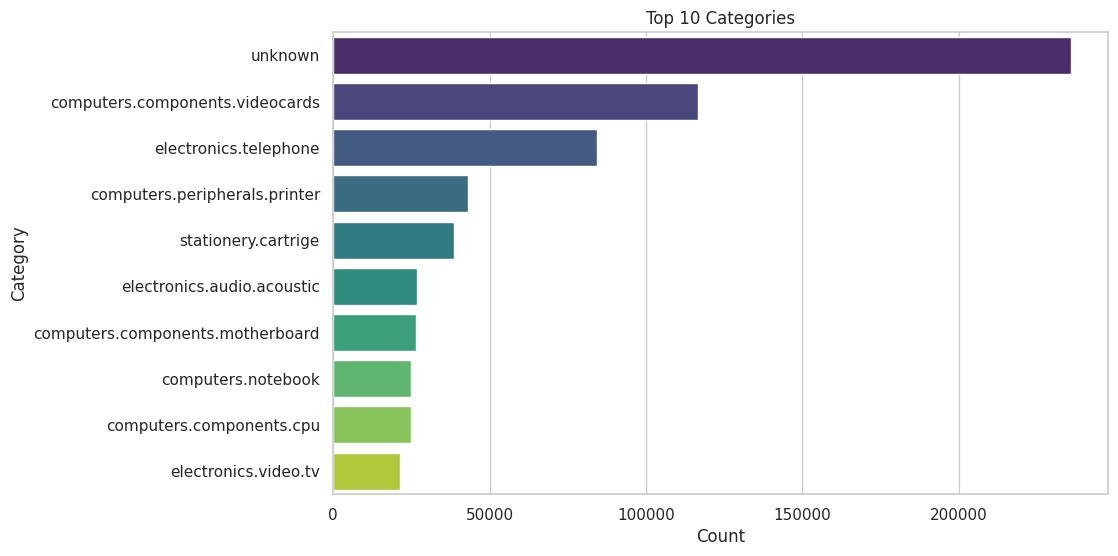


Top 10 Brands:
 brand
unknown      212232
asus          27660
gigabyte      27652
msi           24864
palit         24787
samsung       23188
amd           20095
canon         18430
panasonic     11977
pioneer       11463
Name: count, dtype: int64


<ipython-input-23-ee84b5f15d61>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette="viridis")


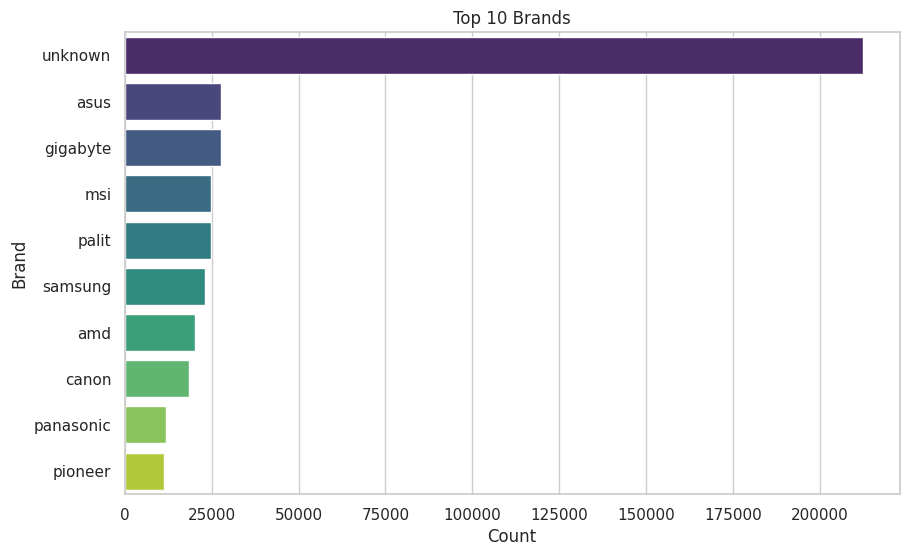

In [23]:
# ------------------------------
# Brand and category popularity
# ------------------------------
print("\nBrand and Category Popularity:")

# Top 10 most popular categories
top_categories = df['category_code'].value_counts().head(10)
print("\nTop 10 Categories:\n", top_categories)

# Plot popular categories
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title('Top 10 Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Top 10 most popular brands
top_brands = df['brand'].value_counts().head(10)
print("\nTop 10 Brands:\n", top_brands)

# Plot popular brands
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.values, y=top_brands.index, palette="viridis")
plt.title('Top 10 Brands')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.show()

**4. User-level summaries**


User-Level Analysis:

Top 10 Users by Spend:
 user_id
1515915625601579158    12080.83
1515915625530137422     9418.62
1515915625547240612     8639.69
1515915625596222123     8047.99
1515915625600723220     7697.54
1515915625591659523     6629.87
1515915625596534847     6286.98
1515915625602773715     5705.96
1515915625604175669     5399.13
1515915625609646735     5332.96
Name: price, dtype: float64


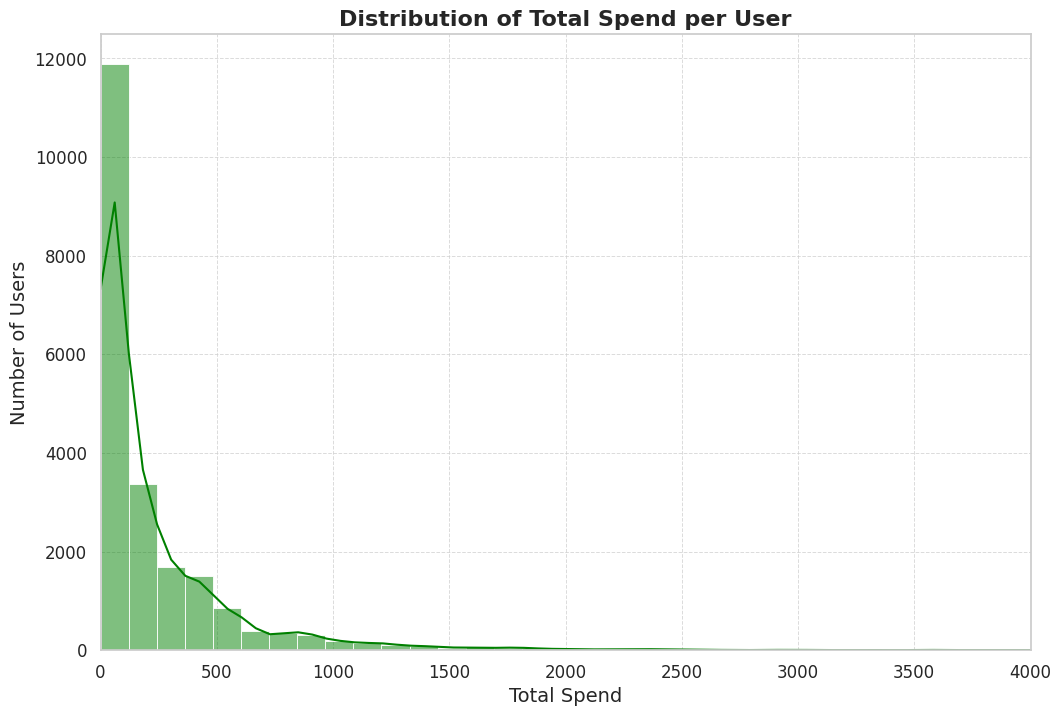

In [24]:
# User-level summaries
print("\nUser-Level Analysis:")

# Total spend per user
user_spend = df[df['event_type'] == 'purchase'].groupby('user_id')['price'].sum().sort_values(ascending=False)
print("\nTop 10 Users by Spend:\n", user_spend.head(10))

# Plot distribution of user spend
plt.figure(figsize=(12, 8))  # Larger figure size
sns.histplot(user_spend, bins=100, kde=True, color="green")  # Increase bins for granularity
plt.title('Distribution of Total Spend per User', fontsize=16, fontweight='bold')
plt.xlabel('Total Spend', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Add gridlines
plt.xlim(0, 4000)  # Restrict x-axis from 0 to 6000
plt.show()


**5. Time slot activity analysis**


Time Slot Analysis:

Hourly Activity:
 event_hour
0     10294
1      9946
2     11168
3     15260
4     20973
5     29739
6     39580
7     46931
8     49908
9     52516
10    53014
11    53568
12    52466
13    50785
14    49299
15    48655
16    49965
17    51726
18    50551
19    45586
20    36959
21    26062
22    17185
23    12338
Name: count, dtype: int64


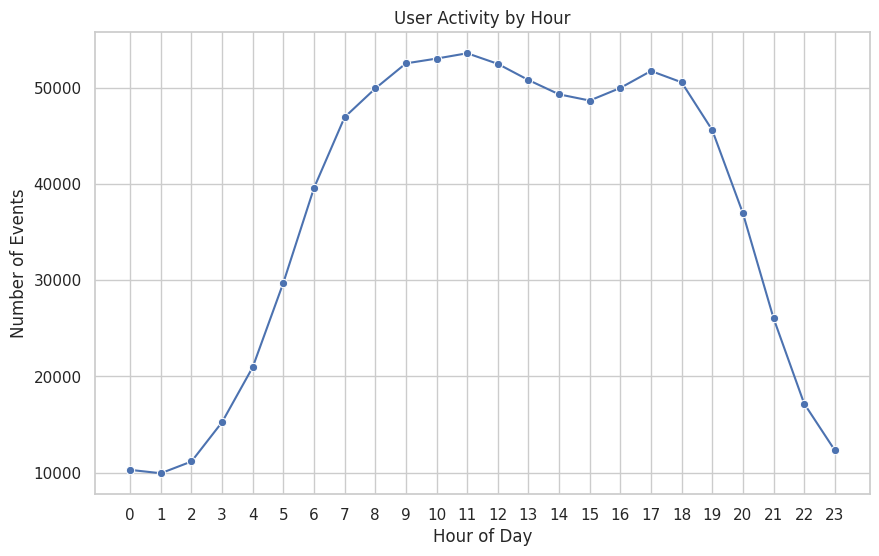

In [25]:
# ------------------------------
# Time slot activity analysis
# ------------------------------
print("\nTime Slot Analysis:")

# Extract hour from event_time
df['event_hour'] = df['event_time'].dt.hour

# User activity by hour
hourly_activity = df['event_hour'].value_counts().sort_index()
print("\nHourly Activity:\n", hourly_activity)

# Plot hourly activity
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_activity.index, y=hourly_activity.values, marker='o')
plt.title('User Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

**6. # Price range analysis**


Price Range Analysis:


<ipython-input-26-6adf68e138cf>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_range_dist = df[df['event_type'].isin(['view', 'purchase'])].groupby(['price_range', 'event_type']).size().unstack()



Price Range Distribution:
 event_type   purchase    view
price_range                  
0-50            15973  331603
50-100           6429  156288
100-200          5355  118793
200-500          8165  150004
500+             1421   36411


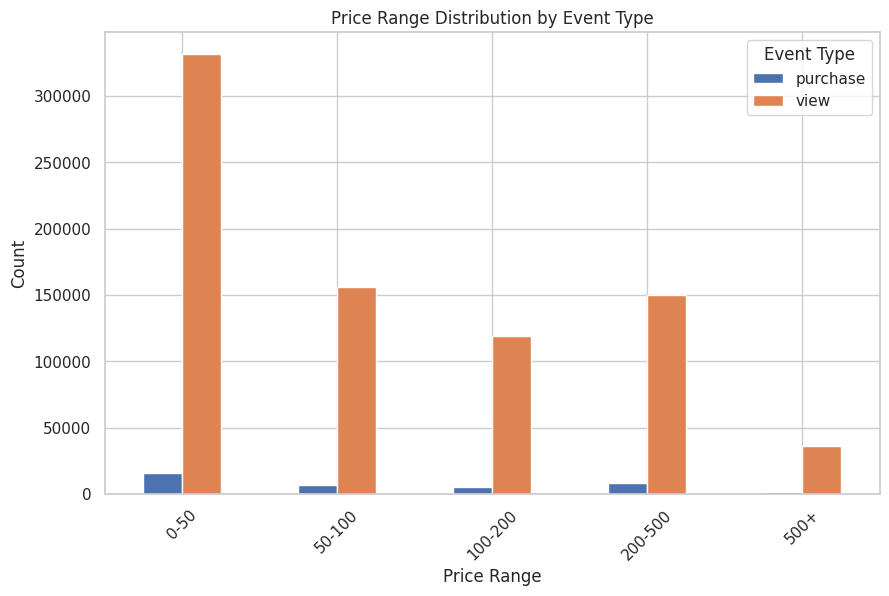

In [26]:
# ------------------------------
# Price range analysis
# ------------------------------
print("\nPrice Range Analysis:")

# Define price bins
price_bins = [0, 50, 100, 200, 500, 1000]
price_labels = ['0-50', '50-100', '100-200', '200-500', '500+']
df['price_range'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, include_lowest=True)

# Price range distribution for views and purchases
price_range_dist = df[df['event_type'].isin(['view', 'purchase'])].groupby(['price_range', 'event_type']).size().unstack()
print("\nPrice Range Distribution:\n", price_range_dist)

# Plot price range distribution
price_range_dist.plot(kind='bar', figsize=(10, 6))
plt.title('Price Range Distribution by Event Type')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title="Event Type")
plt.grid(True)
plt.show()

**7. Most viewed and bought items**

In [27]:
# ------------------------------
# Most viewed and bought items
# ------------------------------
print("\nMost Viewed and Bought Items:")

# Top 10 most viewed products
most_viewed = df[df['event_type'] == 'view']['product_id'].value_counts().head(10)
print("\nTop 10 Most Viewed Products:\n", most_viewed)

# Top 10 most purchased products
most_bought = df[df['event_type'] == 'purchase']['product_id'].value_counts().head(10)
print("\nTop 10 Most Bought Products:\n", most_bought)


Most Viewed and Bought Items:

Top 10 Most Viewed Products:
 product_id
1821813    12794
3791351     5717
4099645     5489
1785245     4630
3829355     4552
809948      3830
1830099     3660
3791509     3150
4154414     3000
893196      2865
Name: count, dtype: int64

Top 10 Most Bought Products:
 product_id
4099645    564
3829355    543
1821813    538
3791351    423
893196     384
3642540    345
4102739    266
287525     261
4154414    257
246841     242
Name: count, dtype: int64


**8.  Session Analysis**


Session Analysis:

Top 10 Users by Number of Sessions:
 user_id
1515915625537803839    254
1515915625568273951    244
1515915625596734979    190
1515915625529330827    166
1515915625533483156    147
1515915625513599785    143
1515915625512176731    131
1515915625539946579     96
1515915625605960935     95
1515915625551553663     84
Name: user_session, dtype: int64


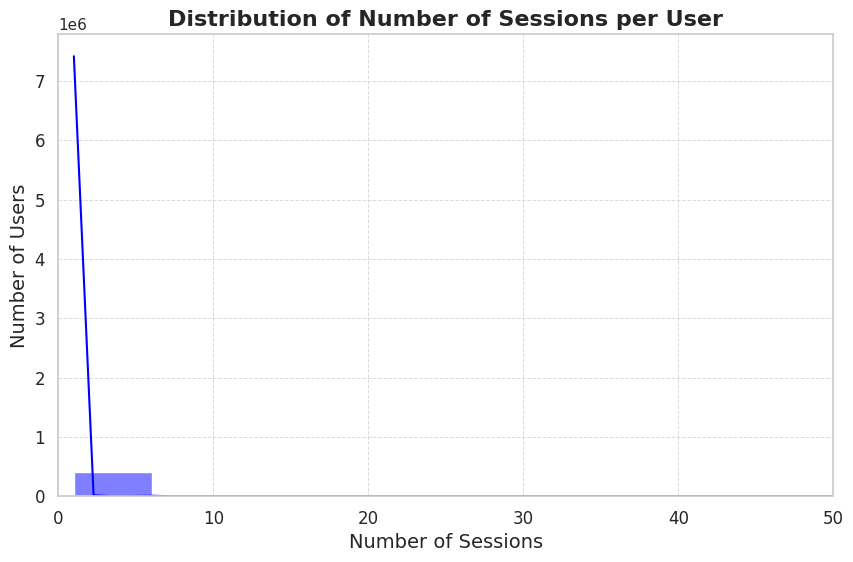

In [28]:
# Session Analysis
print("\nSession Analysis:")

# Number of sessions per user
session_counts = df.groupby('user_id')['user_session'].nunique()
print("\nTop 10 Users by Number of Sessions:\n", session_counts.sort_values(ascending=False).head(10))

# Plot session count distribution
plt.figure(figsize=(10, 6))  # Slightly larger figure size for better clarity
sns.histplot(session_counts, bins=50, kde=True, color="blue")
plt.title('Distribution of Number of Sessions per User', fontsize=16, fontweight='bold')
plt.xlabel('Number of Sessions', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Add gridlines
plt.xlim(0, 50)  # Restrict x-axis from 0 to 50
plt.show()


**9.  Time Between Purchases**


Time Between Purchases:


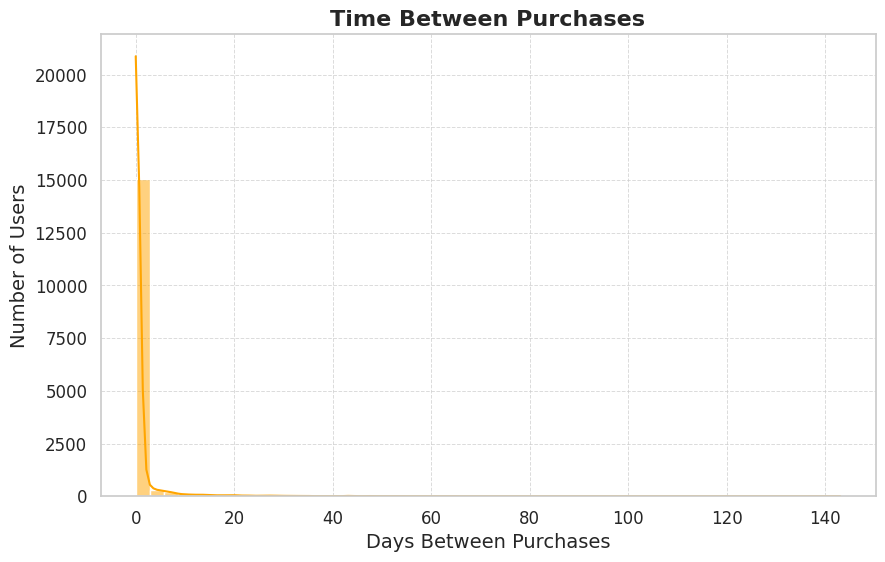

In [29]:
# Time Between Purchases
print("\nTime Between Purchases:")

# Filter purchase events
purchase_df = df[df['event_type'] == 'purchase']

# Calculate time differences between purchases for each user
purchase_df = purchase_df.sort_values(by=['user_id', 'event_time'])
purchase_df['time_diff'] = purchase_df.groupby('user_id')['event_time'].diff().dt.total_seconds() / (60 * 60 * 24)

# Plot distribution of time differences
plt.figure(figsize=(10, 6))  # Larger size for better readability
sns.histplot(purchase_df['time_diff'].dropna(), bins=50, kde=True, color="orange")
plt.title('Time Between Purchases', fontsize=16, fontweight='bold')
plt.xlabel('Days Between Purchases', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Add gridlines
plt.show()


**10. RMF Analysis**

In [30]:
print("="*50)
print("RFM Analysis Report")
print("="*50)

# Recency: Days since last purchase
current_date = pd.to_datetime(df['event_time'].max())  # Ensure it's datetime
rfm = df[df['event_type'] == 'purchase'].groupby('user_id').agg(
    recency=('event_time', lambda x: (current_date - pd.to_datetime(x.max())).days),
    frequency=('user_session', 'nunique'),
    monetary=('price', 'sum')
)

# Normalize RFM for segmentation
# Recency score
rfm['recency_score'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')

# Frequency score
try:
    rfm['frequency_score'] = pd.qcut(rfm['frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
except ValueError:
    rfm['frequency_score'] = pd.cut(rfm['frequency'], bins=4, labels=[1, 2, 3, 4], include_lowest=True)

# Monetary score
try:
    rfm['monetary_score'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')
except ValueError:
    rfm['monetary_score'] = pd.cut(rfm['monetary'], bins=4, labels=[1, 2, 3, 4], include_lowest=True)

# Combine scores to create an RFM segment
rfm['rfm_segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

# Display the RFM table summary
print("\nRFM Table Summary:")
print("-" * 50)
print(f"Total Users Analyzed: {rfm.shape[0]}")
print(f"Recency Range: {rfm['recency'].min()} - {rfm['recency'].max()} days")
print(f"Frequency Range: {rfm['frequency'].min()} - {rfm['frequency'].max()} sessions")
print(f"Monetary Range: ${rfm['monetary'].min():.2f} - ${rfm['monetary'].max():.2f}")
print("-" * 50)

# Show top 5 RFM Segments
print("\nSample of RFM Segments:")
print(rfm.head())
print("="*50)



RFM Analysis Report

RFM Table Summary:
--------------------------------------------------
Total Users Analyzed: 21304
Recency Range: 0 - 157 days
Frequency Range: 1 - 10 sessions
Monetary Range: $0.37 - $12080.83
--------------------------------------------------

Sample of RFM Segments:
                     recency  frequency  monetary recency_score  \
user_id                                                           
1515915625353286099      148          1    119.03             1   
1515915625353457259      152          1     55.16             1   
1515915625353534622      145          1     57.15             1   
1515915625353561691       95          1    345.72             2   
1515915625353900095      136          1     57.85             1   

                    frequency_score monetary_score rfm_segment  
user_id                                                         
1515915625353286099               1              3         113  
1515915625353457259               1          

**11. Churn Indicator**


Churn Analysis:
Number of inactive users (30+ days): 327809


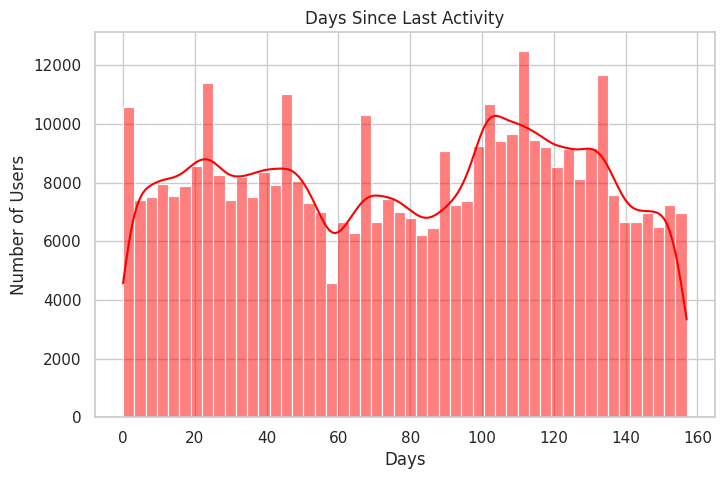

In [31]:
# Churn Indicator
print("\nChurn Analysis:")

# Last activity date
last_activity = df.groupby('user_id')['event_time'].max()
inactive_users = last_activity[last_activity < (current_date - pd.Timedelta(days=30))]
print(f"Number of inactive users (30+ days): {len(inactive_users)}")

# Plot last activity distribution
last_activity_days = (current_date - last_activity).dt.days
plt.figure(figsize=(8, 5))
sns.histplot(last_activity_days, bins=50, kde=True, color="red")
plt.title('Days Since Last Activity')
plt.xlabel('Days')
plt.ylabel('Number of Users')
plt.show()


**12. Event Funnel Analysis**


Funnel Analysis:


<ipython-input-32-911a889f9f80>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funnel.index, y=funnel.values, palette="muted")


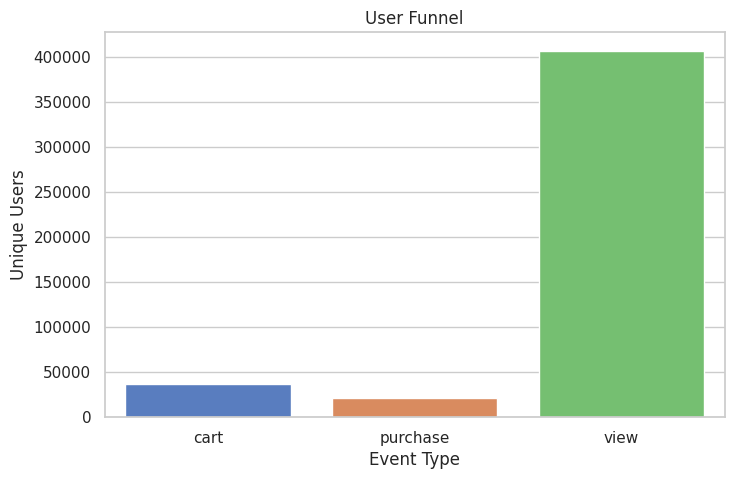


Conversion Rates:
View → Cart: 9.08%
Cart → Purchase: 57.65%


In [32]:
# Event Funnel Analysis
print("\nFunnel Analysis:")

# Count unique users for each event type
funnel = df.groupby('event_type')['user_id'].nunique()
funnel = funnel[['view', 'cart', 'purchase']].sort_index()

# Plot funnel
plt.figure(figsize=(8, 5))
sns.barplot(x=funnel.index, y=funnel.values, palette="muted")
plt.title('User Funnel')
plt.xlabel('Event Type')
plt.ylabel('Unique Users')
plt.show()

# Calculate conversion rates
view_to_cart = (funnel['cart'] / funnel['view']) * 100
cart_to_purchase = (funnel['purchase'] / funnel['cart']) * 100
print(f"\nConversion Rates:\nView → Cart: {view_to_cart:.2f}%\nCart → Purchase: {cart_to_purchase:.2f}%")


**13. Behavioural Clustering**

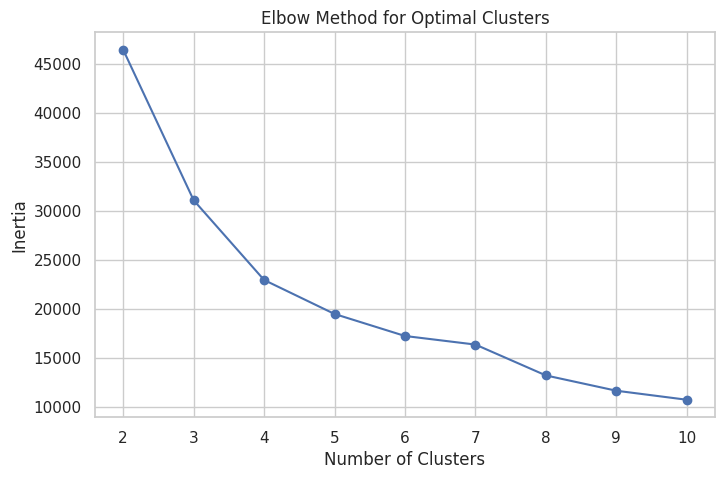

Silhouette Score for 4 clusters: 0.49


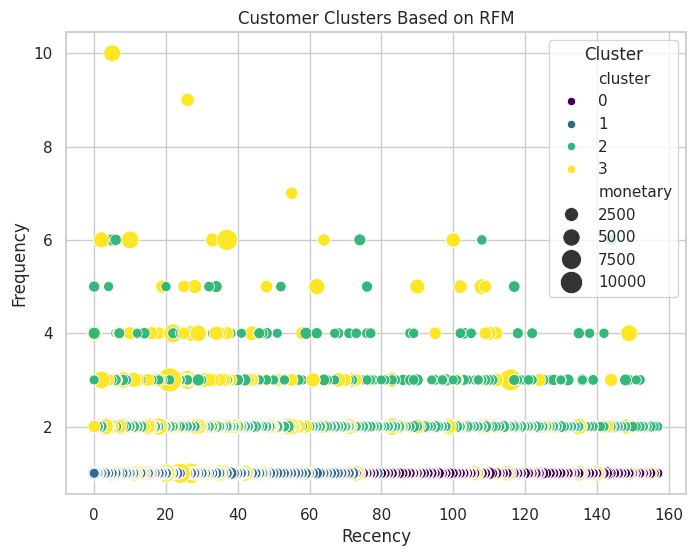

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Scale the RFM data for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Determine optimal number of clusters using the elbow method
inertia = []
for k in range(2, 11):  # Try different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Use silhouette score for validation
best_k = 4  # Adjust based on the elbow curve
kmeans = KMeans(n_clusters=best_k, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

# Silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm['cluster'])
print(f"Silhouette Score for {best_k} clusters: {silhouette_avg:.2f}")

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='recency', y='frequency', hue='cluster', palette='viridis', size='monetary', sizes=(50, 300))
plt.title('Customer Clusters Based on RFM')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()


**14. Heatmap of RFM data**

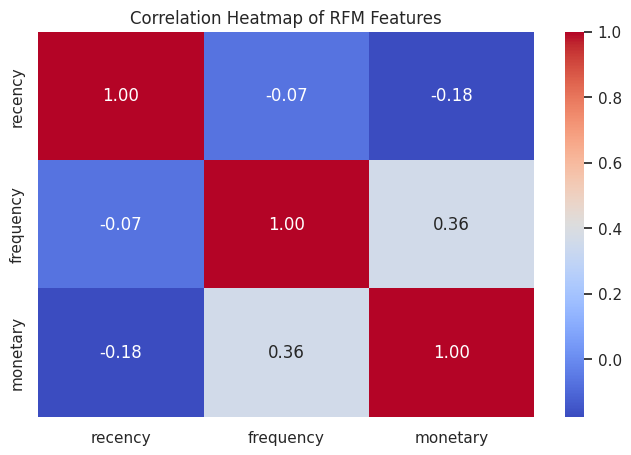

In [34]:
# Heatmap of RFM data
plt.figure(figsize=(8, 5))
sns.heatmap(rfm[['recency', 'frequency', 'monetary']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of RFM Features')
plt.show()


**15. Pairplot for RFM features with cluster labels**

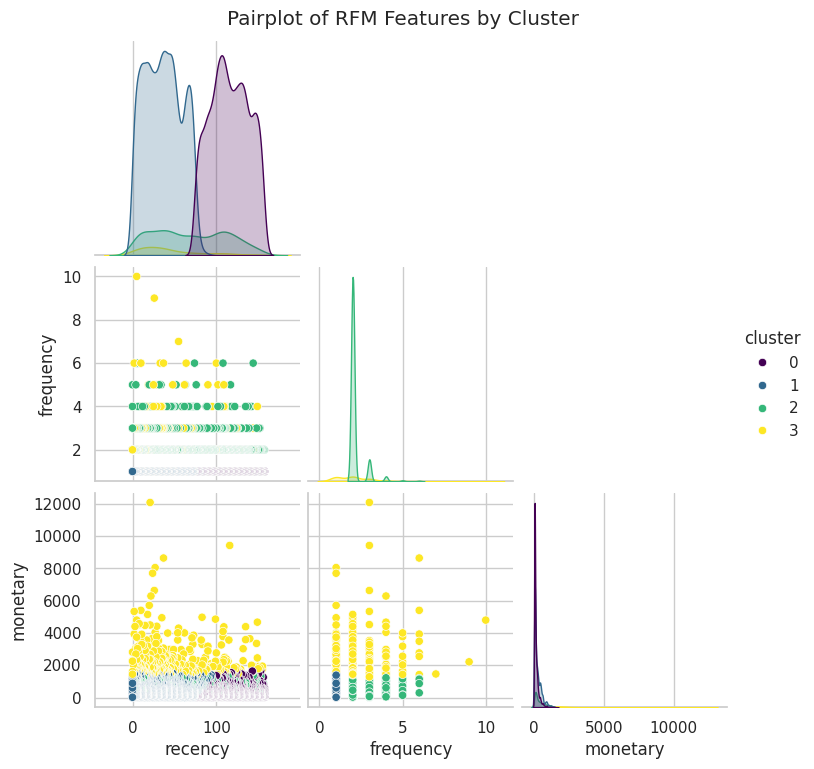

In [35]:
# Pairplot for RFM features with cluster labels
sns.pairplot(rfm, vars=['recency', 'frequency', 'monetary'], hue='cluster', palette='viridis', corner=True)
plt.suptitle('Pairplot of RFM Features by Cluster', y=1.02)
plt.show()


**16. Line plots for Trends**

<ipython-input-36-eb7b62ef41ee>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series = df[df['event_type'] == 'purchase'].groupby(df['event_time'].dt.to_period('M'))['price'].sum()


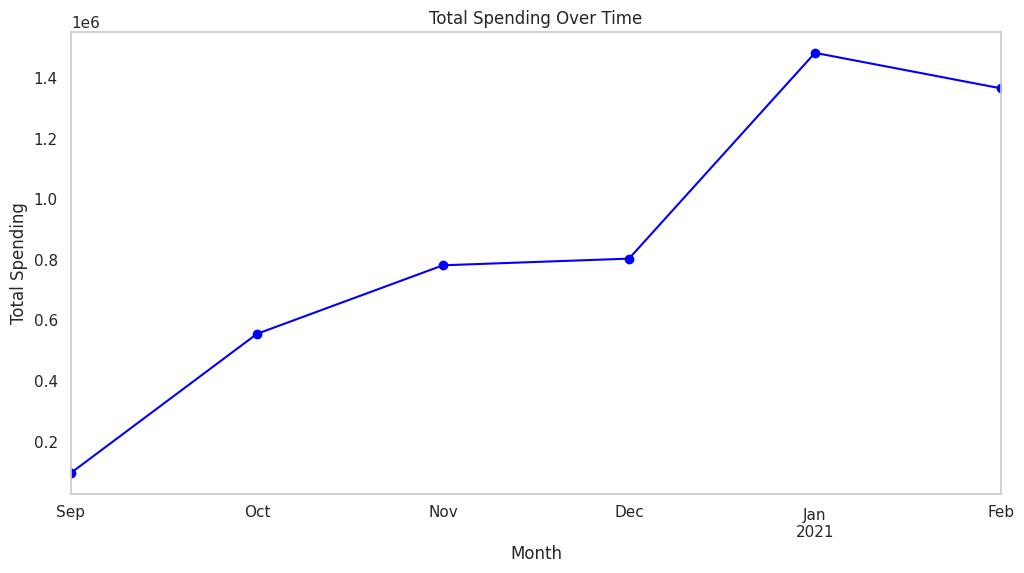

In [36]:
# Aggregate price over time
time_series = df[df['event_type'] == 'purchase'].groupby(df['event_time'].dt.to_period('M'))['price'].sum()

# Plot time series of spending behavior
plt.figure(figsize=(12, 6))
time_series.plot(kind='line', marker='o', color='blue')
plt.title('Total Spending Over Time')
plt.xlabel('Month')
plt.ylabel('Total Spending')
plt.grid()
plt.show()


**Saving EDA**

In [37]:
# ------------------------------
# Save processed EDA outputs if needed
# ------------------------------
eda_output_path = '/content/drive/MyDrive/eda_results.csv'
df.to_csv(eda_output_path, index=False)
print(f"\nEDA dataset with added features saved to {eda_output_path}")


EDA dataset with added features saved to /content/drive/MyDrive/eda_results.csv


# Churn Definition & Reasoning

**Step 1: Define and Validate Churn Threshold**


User Churn Summary:
 churn_status
churned    16557
active      4747
Name: count, dtype: int64


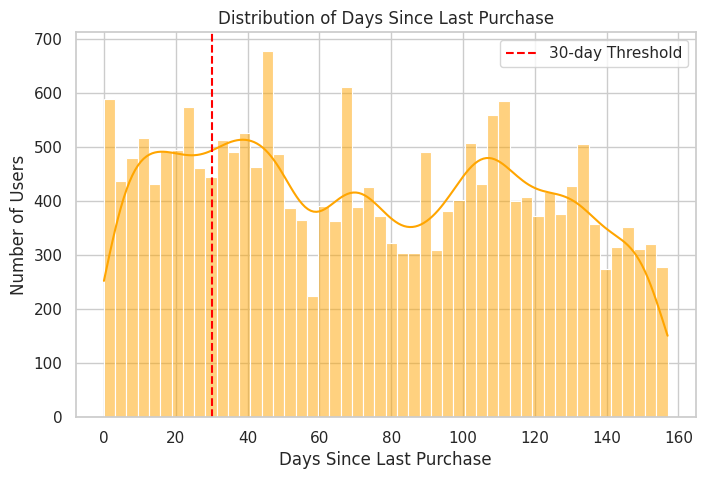

In [38]:
# Define the threshold for churn (30 days)
churn_threshold = 30
current_date = df['event_time'].max()

# Identify last purchase date for each user
user_last_purchase = df[df['event_type'] == 'purchase'].groupby('user_id')['event_time'].max()

# Calculate days since last purchase
days_since_last_purchase = (current_date - user_last_purchase).dt.days

# Mark users as churned or active based on the threshold
user_churn_status = days_since_last_purchase.apply(lambda x: 'churned' if x > churn_threshold else 'active')

# Create a dataframe for analysis
user_churn_analysis = pd.DataFrame({
    'user_id': user_last_purchase.index,
    'days_since_last_purchase': days_since_last_purchase.values,
    'churn_status': user_churn_status.values
})

# Overview of churned vs active users
churn_summary = user_churn_analysis['churn_status'].value_counts()
print("\nUser Churn Summary:\n", churn_summary)

# Visualization: Distribution of days since last purchase
plt.figure(figsize=(8, 5))
sns.histplot(user_churn_analysis['days_since_last_purchase'], bins=50, kde=True, color="orange")
plt.title('Distribution of Days Since Last Purchase')
plt.axvline(churn_threshold, color='red', linestyle='--', label=f'{churn_threshold}-day Threshold')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Users')
plt.legend()
plt.show()


**Step 2: Analyze Behavioral Patterns**

<ipython-input-39-b49e30441a87>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  activity_over_time = df[df['event_type'] == 'purchase'].groupby(df['event_time'].dt.to_period('M')).size()


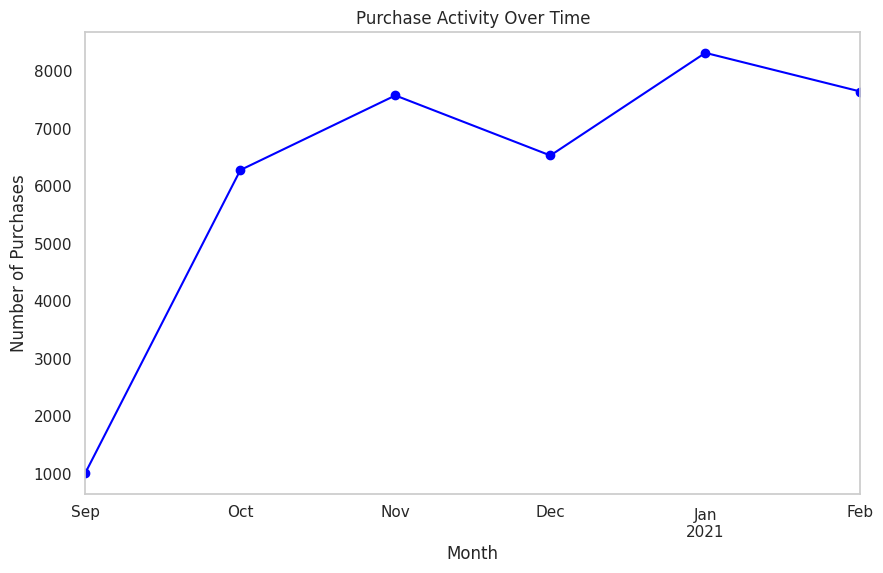


Average Metrics by Churn Status:
               total_spend  num_sessions
churn_status                           
active        2055.987841      2.141142
churned       1243.332391      1.932657


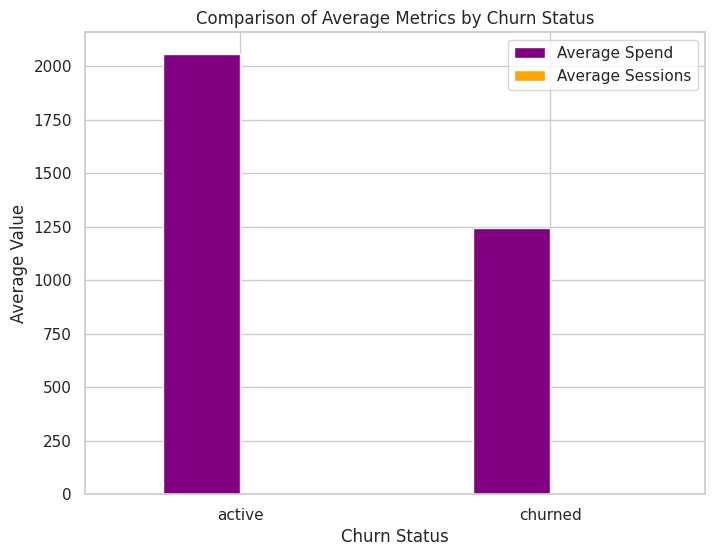

In [39]:
# Analyze user activity over time
activity_over_time = df[df['event_type'] == 'purchase'].groupby(df['event_time'].dt.to_period('M')).size()

# Plot purchase trends over time
plt.figure(figsize=(10, 6))
activity_over_time.plot(kind='line', marker='o', color='blue')
plt.title('Purchase Activity Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.grid()
plt.show()

# Compare activity of churned vs active users
user_metrics = df.groupby('user_id').agg(
    total_spend=('price', 'sum'),
    num_sessions=('user_session', 'nunique'),
    last_purchase_date=('event_time', 'max')
).reset_index()

user_metrics['churn_status'] = user_metrics['user_id'].map(user_churn_status)

# Average spend and sessions by churn status
average_metrics = user_metrics.groupby('churn_status')[['total_spend', 'num_sessions']].mean()
print("\nAverage Metrics by Churn Status:\n", average_metrics)

# Visualize average spend and sessions
average_metrics.plot(kind='bar', figsize=(8, 6), color=['purple', 'orange'])
plt.title('Comparison of Average Metrics by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(['Average Spend', 'Average Sessions'])
plt.show()


**Step 3: Impact of Churn on Revenue**


Revenue Contribution by Churn Status:
 churn_status
active      9759774.28
churned    20585854.40
Name: total_spend, dtype: float64


<ipython-input-40-e356b2329d1b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_status.index, y=revenue_by_status.values, palette='viridis')


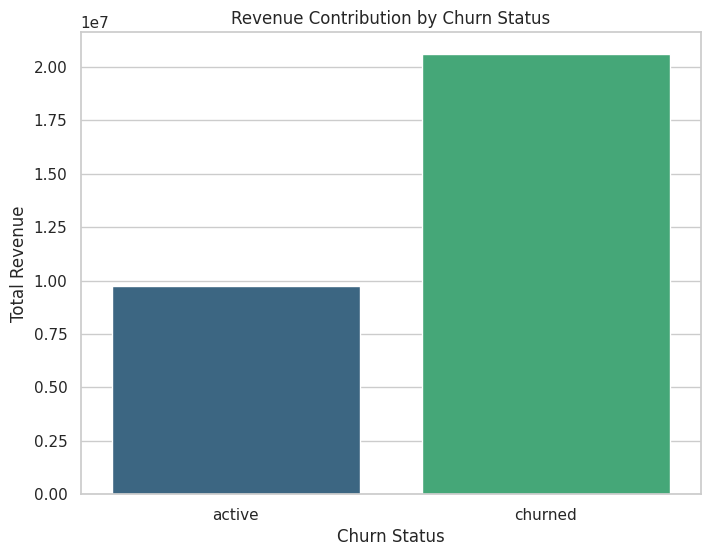

In [40]:
# Revenue contribution by churn status
revenue_by_status = user_metrics.groupby('churn_status')['total_spend'].sum()
print("\nRevenue Contribution by Churn Status:\n", revenue_by_status)

# Visualize revenue contribution
plt.figure(figsize=(8, 6))
sns.barplot(x=revenue_by_status.index, y=revenue_by_status.values, palette='viridis')
plt.title('Revenue Contribution by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Total Revenue')
plt.show()


**Step 4: Additional Segmentation Insights**


RFM Metrics by Churn Status:
                recency  frequency     monetary
churn_status                                  
active        14.17569   2.141142  2055.987841
churned       88.21574   1.932657  1243.332391


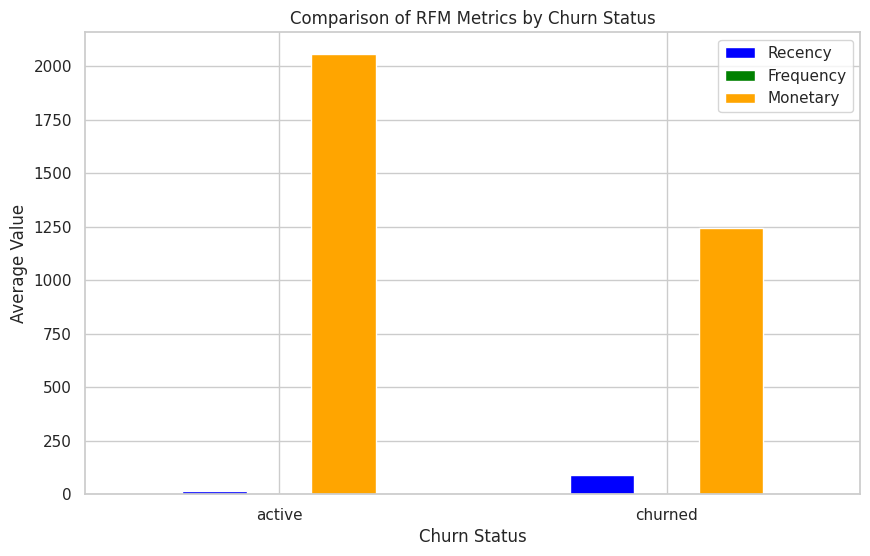

In [41]:
# Segmentation by recency, frequency, and monetary value (RFM analysis)
user_metrics['recency'] = (current_date - user_metrics['last_purchase_date']).dt.days
user_metrics['frequency'] = user_metrics['num_sessions']
user_metrics['monetary'] = user_metrics['total_spend']

# Compare RFM metrics by churn status
rfm_metrics = user_metrics.groupby('churn_status')[['recency', 'frequency', 'monetary']].mean()
print("\nRFM Metrics by Churn Status:\n", rfm_metrics)

# Visualization of RFM metrics
rfm_metrics.plot(kind='bar', figsize=(10, 6), color=['blue', 'green', 'orange'])
plt.title('Comparison of RFM Metrics by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(['Recency', 'Frequency', 'Monetary'])
plt.show()


**Comparing Churn Thresholds**


Churn Distribution by Different Thresholds:
 event_time  churned  active
15            18853    2451
30            16557    4747
60            12156    9148


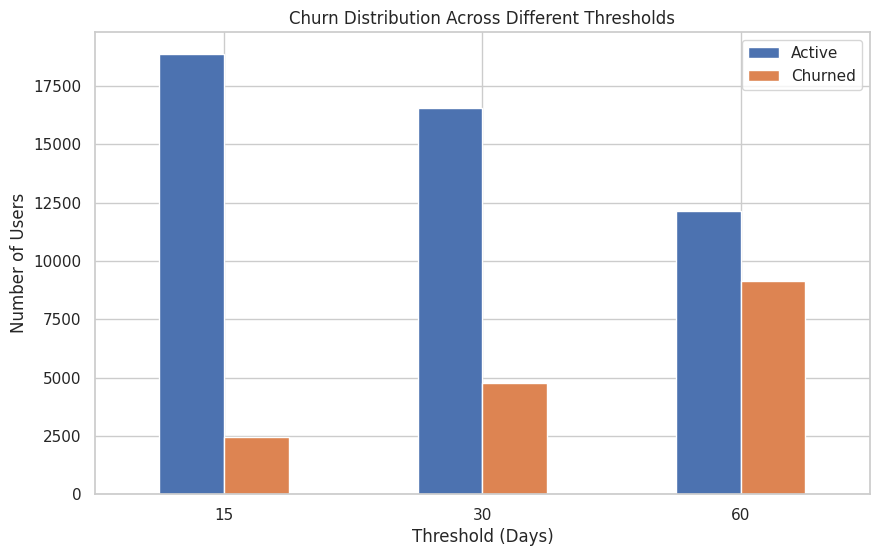

In [42]:
thresholds = [15, 30, 60]
churn_comparison = {}

for threshold in thresholds:
    churn_status = days_since_last_purchase.apply(lambda x: 'churned' if x > threshold else 'active')
    churn_comparison[threshold] = churn_status.value_counts()

churn_df = pd.DataFrame(churn_comparison).T
print("\nChurn Distribution by Different Thresholds:\n", churn_df)

churn_df.plot(kind='bar', figsize=(10, 6))
plt.title('Churn Distribution Across Different Thresholds')
plt.xlabel('Threshold (Days)')
plt.ylabel('Number of Users')
plt.legend(['Active', 'Churned'])
plt.xticks(rotation=0)
plt.show()


**Handling Edge Cases**

In [43]:
# Identify infrequent users (e.g., less than 2 purchases in lifetime)
infrequent_users = user_metrics[user_metrics['frequency'] < 2]
print("\nInfrequent Users:\n", infrequent_users.head())

# Visualize impact of infrequent users on churn
infrequent_churn = infrequent_users['churn_status'].value_counts()
print("\nChurn Distribution Among Infrequent Users:\n", infrequent_churn)



Infrequent Users:
                user_id  total_spend  num_sessions        last_purchase_date  \
0  1515915625353226922        76.48             1 2020-10-29 11:28:35+00:00   
1  1515915625353230067        28.98             1 2020-10-06 06:30:32+00:00   
3  1515915625353230922       274.40             1 2020-10-02 08:23:40+00:00   
4  1515915625353234047      5481.90             1 2021-02-18 09:11:44+00:00   
5  1515915625353236157       179.60             1 2021-02-11 16:10:01+00:00   

  churn_status  recency  frequency  monetary  
0          NaN      122          1     76.48  
1          NaN      145          1     28.98  
3          NaN      149          1    274.40  
4          NaN       10          1   5481.90  
5          NaN       17          1    179.60  

Churn Distribution Among Infrequent Users:
 churn_status
churned    9137
active     2434
Name: count, dtype: int64


**Revenue Retention vs. Acquisition**

In [44]:
avg_acquisition_cost = 50  # Example cost to acquire a new customer
avg_retention_cost = 15    # Example cost to retain a churned user
churned_revenue_loss = revenue_by_status['churned']
potential_savings = churned_revenue_loss - (len(user_churn_analysis[user_churn_analysis['churn_status'] == 'churned']) * avg_retention_cost)

print(f"Potential Revenue Recovery by Retaining Churned Users: ${potential_savings}")


Potential Revenue Recovery by Retaining Churned Users: $20337499.4


# Feature Engineering (Important Section)

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your dataset and includes event_time, event_type, user_id, user_session, price, category_code.

# Convert event_time to datetime if not already done
df['event_time'] = pd.to_datetime(df['event_time'])

# ----------------------------
# Feature 1: RFM Metrics
# ----------------------------
print("\nCalculating RFM Metrics...")

# Recency: Days since last purchase per user
last_event_time = df['event_time'].max()
df_purchase = df[df['event_type'] == 'purchase']
recency = df_purchase.groupby('user_id')['event_time'].max().apply(lambda x: (last_event_time - x).days)

# Frequency: Number of purchases per user
frequency = df_purchase.groupby('user_id')['event_type'].count()

# Monetary: Total spend per user
monetary = df_purchase.groupby('user_id')['price'].sum()

# Combine into RFM DataFrame
rfm = pd.DataFrame({'recency': recency, 'frequency': frequency, 'monetary': monetary}).fillna(0)
print(rfm.describe())

# ----------------------------
# Feature 2: Session-Based Metrics
# ----------------------------
print("\nCalculating Session-Based Metrics...")

# Total sessions per user
sessions_per_user = df.groupby('user_id')['user_session'].nunique()

# Average session duration per user
session_durations = df.groupby(['user_id', 'user_session'])['event_time'].agg(['min', 'max'])
session_durations['duration'] = (session_durations['max'] - session_durations['min']).dt.total_seconds()
avg_session_duration = session_durations.groupby('user_id')['duration'].mean()

# Bounce rate: Sessions with only one event
session_event_counts = df.groupby(['user_id', 'user_session'])['event_type'].count()
bounce_rate = session_event_counts[session_event_counts == 1].groupby('user_id').count() / sessions_per_user

# Combine session features
session_features = pd.DataFrame({
    'total_sessions': sessions_per_user,
    'avg_session_duration': avg_session_duration,
    'bounce_rate': bounce_rate
}).fillna(0)
print(session_features.describe())

# ----------------------------
# Feature 3: Product/Brand Preferences
# ----------------------------
print("\nCalculating Product and Brand Preferences...")

# Most viewed brand per user
most_viewed_brand = df[df['event_type'] == 'view'].groupby('user_id')['category_code'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else "unknown"
)

# Top categories viewed vs. purchased
categories_viewed = df[df['event_type'] == 'view'].groupby('user_id')['category_code'].count()
categories_purchased = df[df['event_type'] == 'purchase'].groupby('user_id')['category_code'].count()
view_purchase_ratio = (categories_viewed / categories_purchased).replace([np.inf, -np.inf], 0).fillna(0)

# Combine product/brand features
product_features = pd.DataFrame({
    'most_viewed_brand': most_viewed_brand,
    'categories_viewed': categories_viewed,
    'categories_purchased': categories_purchased,
    'view_purchase_ratio': view_purchase_ratio
}).fillna(0)
print(product_features.describe())

# ----------------------------
# Feature 4: Behavioral Patterns
# ----------------------------
print("\nCalculating Behavioral Patterns...")

# View-to-cart ratio
views = df[df['event_type'] == 'view'].groupby('user_id')['event_type'].count()
carts = df[df['event_type'] == 'cart'].groupby('user_id')['event_type'].count()
view_to_cart_ratio = (carts / views).replace([np.inf, -np.inf], 0).fillna(0)

# Cart-to-purchase ratio
purchases = df[df['event_type'] == 'purchase'].groupby('user_id')['event_type'].count()
cart_to_purchase_ratio = (purchases / carts).replace([np.inf, -np.inf], 0).fillna(0)

# Combine behavioral features
behavioral_features = pd.DataFrame({
    'view_to_cart_ratio': view_to_cart_ratio,
    'cart_to_purchase_ratio': cart_to_purchase_ratio
}).fillna(0)
print(behavioral_features.describe())

# ----------------------------
# Final Feature Set
# ----------------------------
print("\nCombining All Features...")

# Ensure alignment of all feature DataFrames by user_id
final_features = pd.concat([rfm, session_features, product_features, behavioral_features], axis=1)

# Fill any remaining NaN values with 0 (for edge cases)
final_features = final_features.fillna(0)

# Save features to a CSV for modeling
output_path = '/content/drive/MyDrive/feature_engineering.csv'
final_features.to_csv(output_path, index=True)

print(f"\nFinal Feature Set saved to: {output_path}")
print("\nSample of Final Features:\n", final_features.head())



Calculating RFM Metrics...
            recency     frequency      monetary
count  21304.000000  21304.000000  21304.000000
mean      73.549709      1.752863    238.339775
std       45.094819      1.741980    414.644025
min        0.000000      1.000000      0.370000
25%       34.000000      1.000000     32.220000
50%       71.000000      1.000000     90.630000
75%      112.000000      2.000000    287.457500
max      157.000000     56.000000  12080.830000

Calculating Session-Based Metrics...
       total_sessions  avg_session_duration    bounce_rate
count   407283.000000          4.072830e+05  407283.000000
mean         1.204993          2.364308e+04       0.734080
std          1.279001          2.779475e+05       0.424973
min          1.000000          0.000000e+00       0.000000
25%          1.000000          0.000000e+00       0.500000
50%          1.000000          0.000000e+00       1.000000
75%          1.000000          3.300000e+01       1.000000
max        254.000000         

# Model Building and Training

Class distribution in the test set:
churn
0    169557
1      7469
Name: count, dtype: int64


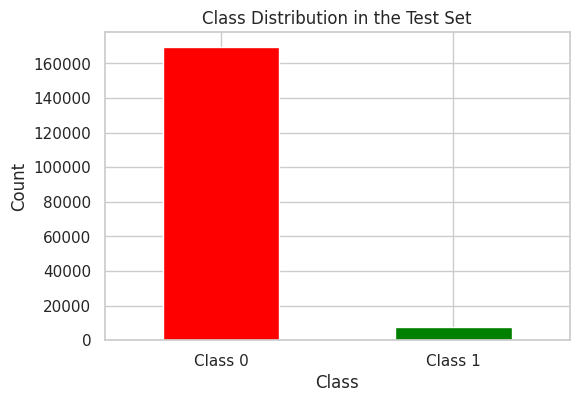

In [46]:
# Check for class imbalance in the test set
print("Class distribution in the test set:")
print(y_test.value_counts())

# Optionally, you can visualize the distribution as well
plt.figure(figsize=(6, 4))
y_test.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Class Distribution in the Test Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Class 0', 'Class 1'], rotation=0)
plt.show()


**Initial errorous model**
**Overfitting and poor training**


Training LightGBM Model...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 1	valid's auc: 0.999988
Early stopping, best iteration is:
[2]	train's auc: 0.999999	valid's auc: 0.999991


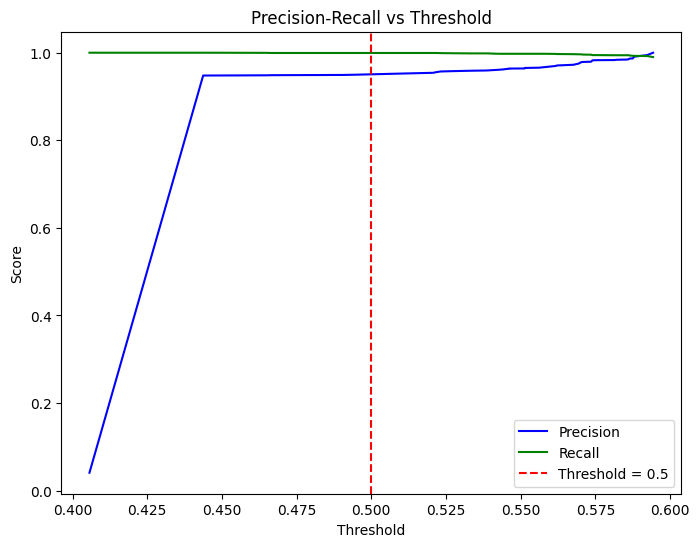


Optimal Threshold: 0.5943247866136621

Model Performance:
Accuracy: 0.9593527873602024
Precision: 1.0
Recall: 0.0
F1-Score: 0.0
AUC-ROC: 0.9999907977619941

Confusion Matrix:
[[78146     0]
 [ 3311     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     78146
           1       1.00      0.00      0.00      3311

    accuracy                           0.96     81457
   macro avg       0.98      0.50      0.49     81457
weighted avg       0.96      0.96      0.94     81457



In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load features
df = pd.read_csv('/content/drive/MyDrive/feature_engineering.csv')

# Define target variable (e.g., churn)
df['churn'] = (df['recency'] > 30).astype(int)  # Example churn definition

# Drop unnecessary columns
X = df.drop(['user_id', 'churn'], axis=1, errors='ignore')  # Handle missing 'user_id' gracefully
y = df['churn']

# Encode categorical features
if 'most_viewed_brand' in X.columns:
    le = LabelEncoder()
    X['most_viewed_brand'] = le.fit_transform(X['most_viewed_brand'])

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_jobs': -1,  # Use all CPU cores
    'max_depth': 8,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Handle class imbalance
}

# Train LightGBM model
print("\nTraining LightGBM Model...")
lgb_train = lgb.Dataset(X_train_balanced, label=y_train_balanced)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

gbm = lgb.train(
    params=params,
    train_set=lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

# Predictions and Evaluation
y_proba = gbm.predict(X_test)

# Precision-Recall Curve and Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot threshold vs precision/recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.show()

# Find the optimal threshold (e.g., maximizing F1 score)
optimal_idx = np.argmax(2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1]))
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold}")

# Apply the threshold
y_pred = (y_proba > optimal_threshold).astype(int)

# Evaluation Metrics
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=1))
print("Recall:", recall_score(y_test, y_pred, zero_division=1))
print("F1-Score:", f1_score(y_test, y_pred, zero_division=1))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))


**Model improvement with accuracy of 47%**


Training Fold 1...
[LightGBM] [Info] Number of positive: 542580, number of negative: 542581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 1085161, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000002
[LightGBM] [Info] Start training from score -0.000002
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.683278	valid's auc: 0.684389
[100]	train's auc: 0.713723	valid's auc: 0.714271
[150]	train's auc: 0.731301	valid's auc: 0.731473
[200]	train's auc: 0.743372	valid's auc: 0.743311
[250]	train's auc: 0.750696	valid's auc: 0.750256
[300]	train's auc: 0.757517	valid's auc: 0.756832
[350]	train's auc: 0.763724	valid's auc: 0.762917
[400]	train's auc: 0.768587	valid's auc: 0.767673
[450]	train's auc: 0.77

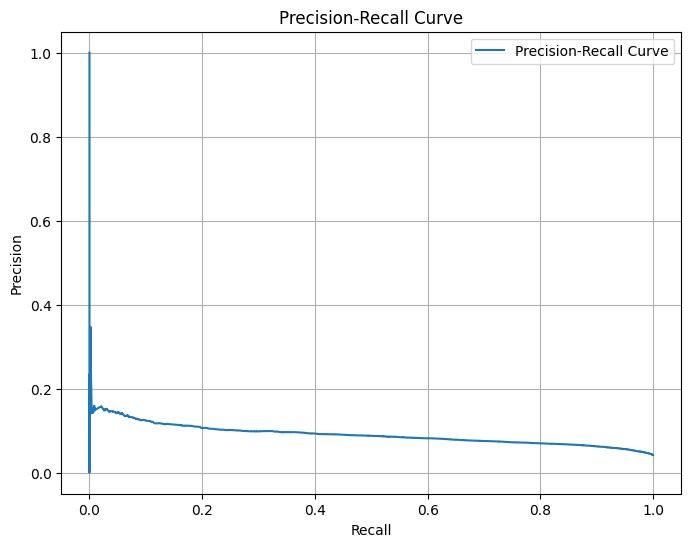

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/events.csv')

# Data Preprocessing
df['event_time'] = pd.to_datetime(df['event_time'])

# Define the target variable (e.g., purchase events)
df['churn'] = (df['event_type'] == 'purchase').astype(int)

# Drop unnecessary columns
X = df.drop(['user_id', 'user_session', 'event_type', 'event_time', 'churn'], axis=1)
y = df['churn']

# Encode categorical variables
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].fillna('Unknown'))

# Split into train-test sets ensuring no data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM model
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 8,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}

best_thresholds = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_balanced, y_train_balanced)):
    print(f"\nTraining Fold {fold + 1}...")
    X_tr, X_val = X_train_balanced[train_idx], X_train_balanced[val_idx]
    y_tr, y_val = y_train_balanced[train_idx], y_train_balanced[val_idx]

    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    # Predict probabilities
    y_proba = model.predict(X_val)

    # Precision-Recall Curve and Optimal Threshold
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.argmax(f1_scores)
    best_threshold = thresholds[optimal_idx]
    best_thresholds.append(best_threshold)

    # Apply the optimal threshold
    y_pred = (y_proba > best_threshold).astype(int)

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision_score_val = precision_score(y_val, y_pred)
    recall_score_val = recall_score(y_val, y_pred)
    f1_score_val = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_proba)

    fold_metrics.append((accuracy, precision_score_val, recall_score_val, f1_score_val, auc_roc))
    print(f"Fold {fold + 1} Metrics:")
    print(f"Accuracy: {accuracy}, Precision: {precision_score_val}, Recall: {recall_score_val}, F1-Score: {f1_score_val}, AUC-ROC: {auc_roc}")

# Final Evaluation on Test Set
final_threshold = np.mean(best_thresholds)
y_proba_test = model.predict(X_test)
y_pred_test = (y_proba_test > final_threshold).astype(int)

print("\nFinal Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision: {precision_score(y_test, y_pred_test)}")
print(f"Recall: {recall_score(y_test, y_pred_test)}")
print(f"F1-Score: {f1_score(y_test, y_pred_test)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_test)}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Feature Importance
print("\nFeature Importance:")
importance = model.feature_importance(importance_type='gain')
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
print(importance_df.sort_values(by='Importance', ascending=False))

# Visualize Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


# **Final model with accuracy of 82.2%**

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Testing Parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'scale_pos_weight': 1, 'num_threads': -1}
[LightGBM] [Info] Number of positive: 452150, number of negative: 452151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 904301, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000002
[LightGBM] [Info] Start training from score -0.000002
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.661591	valid's auc: 0.661929
[100]	train's auc: 0.66628	valid's auc: 0.666712
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.66628	valid's auc: 0.

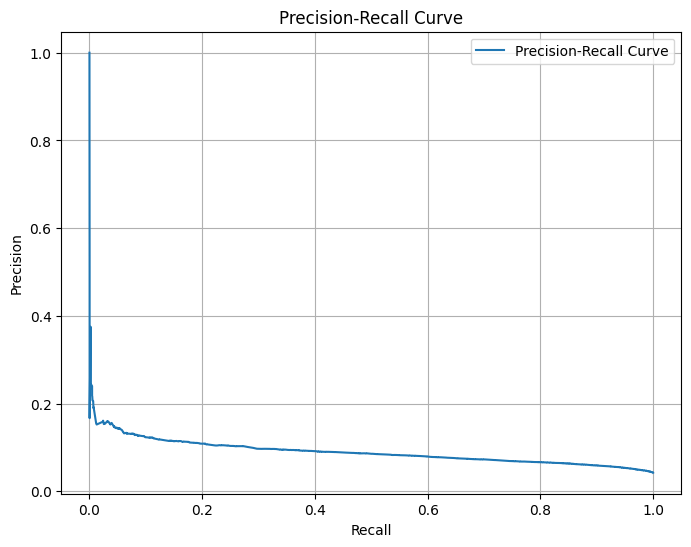

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterSampler

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/events.csv')

# Data Preprocessing
df['event_time'] = pd.to_datetime(df['event_time'])
df['churn'] = (df['event_type'] == 'purchase').astype(int)

# Drop unnecessary columns
X = df.drop(['user_id', 'user_session', 'event_type', 'event_time', 'churn'], axis=1)
y = df['churn']

# Encode categorical variables
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].fillna('Unknown'))

# Train-test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced to 3 folds

# Hyperparameter grid (reduced)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'num_leaves': [31, 63],
    'feature_fraction': [0.8],
    'bagging_fraction': [0.8],
    'scale_pos_weight': [1]
}

# Randomly sample parameter combinations (instead of testing all combinations)
param_combinations = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

best_auc = 0
best_params = None
best_model = None

# Hyperparameter tuning
for params in param_combinations:
    current_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': params['learning_rate'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': 5,
        'scale_pos_weight': params['scale_pos_weight'],
        'num_threads': -1  # Added num_threads
    }

    print(f"\nTesting Parameters: {current_params}")
    fold_aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_balanced, y_train_balanced)):
        X_tr, X_val = X_train_balanced[train_idx], X_train_balanced[val_idx]
        y_tr, y_val = y_train_balanced[train_idx], y_train_balanced[val_idx]

        lgb_train = lgb.Dataset(X_tr, label=y_tr)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

        model = lgb.train(
            params=current_params,
            train_set=lgb_train,
            num_boost_round=100,  # Reduced num_boost_round to 100
            valid_sets=[lgb_train, lgb_val],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=50)
            ]
        )

        y_proba = model.predict(X_val)
        auc = roc_auc_score(y_val, y_proba)
        fold_aucs.append(auc)

    avg_auc = np.mean(fold_aucs)
    print(f"Average AUC-ROC for this configuration: {avg_auc}")

    if avg_auc > best_auc:
        best_auc = avg_auc
        best_params = current_params
        best_model = model

print("\nBest Parameters Found:")
print(best_params)
print(f"Best Validation AUC-ROC: {best_auc}")

# Evaluate on Test Set
y_proba_test = best_model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
final_threshold = thresholds[optimal_idx]

y_pred_test = (y_proba_test > final_threshold).astype(int)

print("\nFinal Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision: {precision_score(y_test, y_pred_test)}")
print(f"Recall: {recall_score(y_test, y_pred_test)}")
print(f"F1-Score: {f1_score(y_test, y_pred_test)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_test)}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Visualize Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()
